# FYS-STK4155 - Project 1

## By Jørn Marcus Høylo Rosenberg and Andreas Dyve

This Notebook contains both the code for the project and the report. The notebook is structured with each exercise in its own cell(s). This leads to some repeting code, but is practical for the purpose of evaluating each task seperately. (eller noe i denne duren?)

### Table of Contents

* [1. Imported libraries](#imports)
* [2. Functions used throughout the project](#functions)
    * [2.1. Franke function](#frankefunction)
    * [2.2. Cost functions](#costfunctions) 
    * [2.3. Design matrix function](#Xfunction)
    * [2.4. Scaling function](#scalefunction)
* [3. Exercise 1](#3)
    * [3.1. OLS regression](#3.1)
    * [3.2. Confidence intervals](#3.2)
    * [3.3. Discussion on scaling](3.3)
* [4. Exercise 2](#4)
    * [4.1. OLS regression with bootstrap](#4.1)
    * [4.2. bias-variance trade-off](#4.2)
* [5. Exercise 3](#5)
    * [5.1. OLS regression with cross-validation](#5.1)
    * [5.2. Comparison with bootstrap](#5.2)
* [6. Exercise 4](#6)
    * [6.1. Ridge regression with bootstrap and cross-validation](#6.1)
    * [6.2. Discussion of lambda](#6.2)
* [7. Exercise 5](#7)
    * [7.1 Lasso regression with bootstrap and cross-validation](#7.1)
    * [7.2 Evaluation of models](#7.2)
* [8. Exercise 6](#8)

### 1. Imported libraries <a class="anchor" id="imports"></a>

In [1]:
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.utils import resample

### 2. Functions used throughout the project <a class="anchor" id="functions"></a>

The following functions are used for much of the repetative tasks in this project

#### 2.1. Error functions <a class="anchor" id="errorfunctions"></a>

In [2]:
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

#### 2.2. Franke function <a class="anchor" id="frankefunction"></a>

The provided code in the exercise set is used for making and plotting of the Franke function.

ValueError: operands could not be broadcast together with shapes (20,20) (400,) 

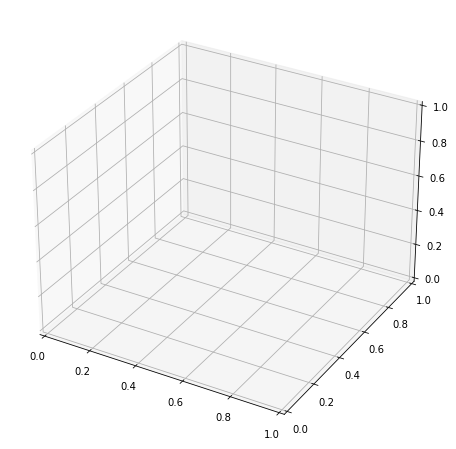

In [6]:
fig = plt.figure(figsize=(20,8))
ax = fig.gca(projection='3d')

# Make data.
N = 20
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)

def FrankeFunction(x,y,noise_coef):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    noise = noise_coef * np.random.randn(N*N)
    return term1 + term2 + term3 + term4 + noise


z = FrankeFunction(x, y, 0.15)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set_xlabel('X', fontsize=15)
ax.set_ylabel('Y', fontsize=15)
ax.set_zlabel('Z', fontsize=15)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

#### 2.3. Design matrix function <a class="anchor" id="Xfunction"></a>

The provided code is used for computing the design matrix

In [7]:
def create_X(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of columns in beta
    X = np.ones((N,l)) 

    for i in range(1,n+1):
        q = int((i)*(i+1)/2) 
        for k in range(i+1): 
            X[:,q+k] = (x**(i-k))*(y**k)

    return X

#### 2.4. Scaling function <a class="anchor" id="scalefunction"></a>

In [8]:
def scale(X_train, X_test, z_train, z_test):
    scaler = StandardScaler() # Utilizing scikit's standardscaler

    scaler_x = scaler.fit(X_train) # Scaling x-data
    X_train_scaled = scaler_x.transform(X_train)
    X_test_scaled = scaler_x.transform(X_test)

    scaler_z = scaler.fit(z_train.reshape(-1,1)) # Scaling z-data
    z_train_scaled = scaler_z.transform(z_train.reshape(-1,1)).ravel()
    z_test_scaled = scaler_z.transform(z_test.reshape(-1,1)).ravel()

    return X_train_scaled, X_test_scaled, z_train_scaled, z_test_scaled

## 3. Exercise 1: OLS on the Franke function <a class="anchor" id="3"></a>

The goal of this task is to do an OLS regression analysis of the Franke function for a polynomial degree up to 5. The OLS is implemented in the following way:
> $ \beta = $ blablba

#### 3.1. OLS regression code <a class="anchor" id="3.1"></a>

The following code creates the dataset and does an OLS regression analysis.

Degree: 0   mse train: 0.122099   mse test: 0.120400   r2_train: 0.000000   r2 test: -0.022898
Degree: 1   mse train: 0.035851   mse test: 0.032050   r2_train: 0.706376   r2 test: 0.727711
Degree: 2   mse train: 0.027865   mse test: 0.027483   r2_train: 0.771781   r2 test: 0.766509
Degree: 3   mse train: 0.016377   mse test: 0.015843   r2_train: 0.865869   r2 test: 0.865404
Degree: 4   mse train: 0.012577   mse test: 0.011294   r2_train: 0.896990   r2 test: 0.904052
Degree: 5   mse train: 0.011121   mse test: 0.011840   r2_train: 0.908919   r2 test: 0.899412


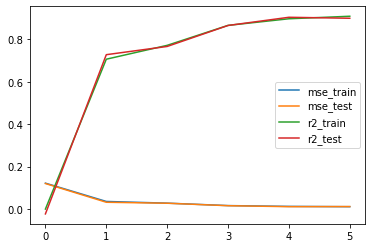

In [6]:
# Making meshgrid of datapoints and compute Franke's function
maxdegrees = 5
N = 20
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)

z = FrankeFunction(x_flat, y_flat, 0.1*np.random.randn(N*N))

polydegree = np.zeros(maxdegrees+1)
r2_train = np.zeros(maxdegrees+1)
r2_test = np.zeros(maxdegrees+1)
mse_train = np.zeros(maxdegrees+1)
mse_test = np.zeros(maxdegrees+1)

# OLS regression for polynomials from 0 to maxdegrees
for i in range(maxdegrees+1):
    degree = i
    polydegree[i] = degree
    X = create_X(x_flat, y_flat, degree)
    X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2, random_state=42)
    #X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)
    
    # prediction
    betaOLS = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
    ztilde_train = X_train @ betaOLS
    ztilde_test = X_test @ betaOLS
    
    # cost functions
    r2_train[i] = r2_score(z_train, ztilde_train)
    r2_test[i] = r2_score(z_test, ztilde_test)
    mse_train[i] = MSE(z_train,ztilde_train) 
    mse_test[i] = MSE(z_test,ztilde_test) #mean_squared_error(z_test, ztilde_test)
    print('Degree: %i   mse train: %.6f   mse test: %.6f   r2_train: %.6f   r2 test: %.6f'\
          %(degree, mse_train[i], mse_test[i], r2_train[i], r2_test[i]))

plt.plot(polydegree, mse_train, label='mse_train')
plt.plot(polydegree, mse_test, label='mse_test')
plt.plot(polydegree, r2_train, label='r2_train')
plt.plot(polydegree, r2_test, label='r2_test')
plt.legend()
plt.show()

#### 3.2. Confidence intervals <a class="anchor" id="3.2"></a>

- $\mu_{\beta} \pm \frac{2\sigma_{\beta}}{\sqrt{n}}$

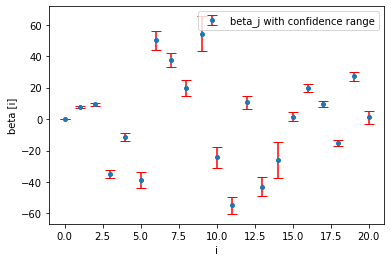

,Beta,+-
0,0.039967,0.067710
1,7.823816,0.561593
2,9.562776,0.948249
3,-35.019301,2.748881
4,-11.383479,2.239945
5,-38.765040,4.953336
6,49.969481,6.273169
7,37.549341,4.664594
8,19.513614,5.081288
9,54.240846,11.138731


In [7]:
variance = np.zeros(len(betaOLS))
CI = np.zeros(len(betaOLS))

for i in range(len(betaOLS)):
    variance[i] = 0.1**2 * np.linalg.pinv(X_train.T @ X_train)[i,i]
    CI[i] = 2*np.sqrt(variance[i])/np.sqrt(N)

plt.errorbar(np.arange(0,len(betaOLS)), betaOLS, yerr=CI, fmt='o', ecolor='red', capsize=5, markersize=4, label='beta_j with confidence range')
plt.xlabel('i')
plt.ylabel('beta [i]')
plt.legend()
plt.show()

table = pd.DataFrame({'Beta': betaOLS, '+-': CI})
table

#### 3.3 Discussion on scaling <a class="anchor" id="3.3"></a>

### 4. Exercise 2 - Bias-variance trade-off and resampling techniques 
<a class="anchor" id="4"></a>

#### Notes
- scaling or not scaling - no difference as expected (ref notes exercise 1)
- Increasing from 50 bootstraps gives no improved results
- Increasing N from 100 only smoothens the curve
- Polynomial degree above 10 does not decrease errors

#### 4.1. OLS regression with bootstrap resampling <a class="anchor" id="4.1"></a>

degree: 0    mse: 1.440723    bias: 1.440723    variance: 0.000000
degree: 1    mse: 0.582708    bias: 0.579693    variance: 0.003015
degree: 2    mse: 0.559894    bias: 0.552413    variance: 0.007481
degree: 3    mse: 0.286937    bias: 0.271045    variance: 0.015892
degree: 4    mse: 0.332429    bias: 0.314781    variance: 0.017647
degree: 5    mse: 0.437245    bias: 0.374523    variance: 0.062722
degree: 6    mse: 0.267234    bias: 0.244661    variance: 0.022573
degree: 7    mse: 0.393427    bias: 0.332294    variance: 0.061133
degree: 8    mse: 0.467450    bias: 0.372830    variance: 0.094619
degree: 9    mse: 1.836629    bias: 0.522469    variance: 1.314160
degree: 10    mse: 3.973155    bias: 0.584781    variance: 3.388373
degree: 11    mse: 3.497928    bias: 0.777047    variance: 2.720881


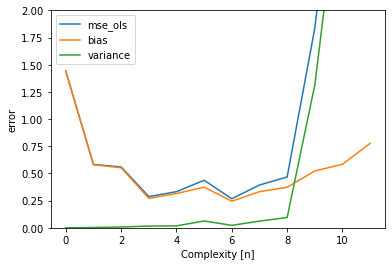

In [8]:
# Parameters
N = 20
n_bootstraps = 1000
maxdegree = 12

# Create data
np.random.seed(64)
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)

z = FrankeFunction(x_flat, y_flat, 0.15)

# Cost functions
mse_error = np.zeros(maxdegree)
r2_error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
mse_est = np.zeros(maxdegree)


polydegree = np.zeros(maxdegree)
for i in range(maxdegree):
    degree = i
    polydegree[i] = degree
    X = create_X(x_flat, y_flat, degree)

    X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)
    X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)

    z_pred = np.empty((z_test.shape[0], n_bootstraps))
    for j in range(n_bootstraps):
        x_bs,z_bs = resample(X_train, z_train)
        beta_ols = np.linalg.pinv(x_bs.T @ x_bs) @ x_bs.T @ z_bs
        z_pred[:,j] = X_test @ beta_ols
    
    mse_error[i] = np.mean(np.mean((z_test.reshape(-1,1) - z_pred)**2, axis=1, keepdims=True))
    bias[i] = np.mean((z_test.reshape(-1,1) - np.mean(z_pred, axis=1, keepdims=True))**2)
    variance[i] = np.mean(np.var(z_pred, axis=1, keepdims=True))
    
    print('degree: %i    mse: %.6f    bias: %.6f    variance: %.6f' \
          %(degree, mse_error[i], bias[i], variance[i]))
    

plt.plot(polydegree, mse_error, label='mse_ols')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='variance')
plt.xlabel('Complexity [n]')
plt.ylabel('error')
plt.ylim(0,2)
plt.legend()
plt.show()

#### 4.2. Discussion of bias-variance trade-off <a class="anchor" id="4.2"></a>

### 5. Exercise 3 - Cross validation as resampling technique, adding more complexity 
<a class="anchor" id="5"></a>

#### 5.1. OLS regression with cross-validation resampling <a class="anchor" id="5.1"></a>

degree: 0    mse: 1.014967    scikit mse: -0.094468
degree: 1    mse: 0.543536    scikit mse: -0.050611
degree: 2    mse: 0.460891    scikit mse: -0.042991
degree: 3    mse: 0.327560    scikit mse: -0.030584
degree: 4    mse: 0.314723    scikit mse: -0.029365
degree: 5    mse: 0.298608    scikit mse: -0.027879
degree: 6    mse: 0.283374    scikit mse: -0.028802
degree: 7    mse: 0.293943    scikit mse: -0.031155
degree: 8    mse: 0.320473    scikit mse: -0.033205
degree: 9    mse: 0.368816    scikit mse: -0.036215
degree: 10    mse: 0.451438    scikit mse: -0.048001
degree: 11    mse: 0.619847    scikit mse: -0.060673


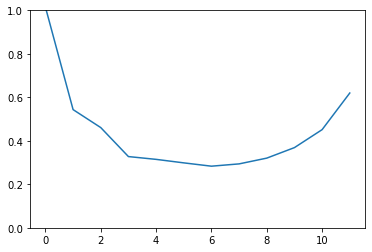

-0.06067256052363421


In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Parameters
N = 20
maxdegree = 12
k = 10
kfold = KFold(n_splits = k, shuffle=True, random_state=22)

# Make dataset
np.random.seed(64)
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)
z = FrankeFunction(x_flat, y_flat, 0.15)

# Cost function
mse_ols_cvd = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)

for i in range(maxdegree):
    degree = i
    polydegree[i] = degree
    X = create_X(x_flat, y_flat, degree)
    mse_split = np.zeros(k)
    cv_split = 0
    for train_indexes, test_indexes in kfold.split(X):
        X_train = X[train_indexes]
        X_test = X[test_indexes]
        z_train = z[train_indexes]
        z_test = z[test_indexes]
        X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)

        beta = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
        z_pred = X_test @ beta
        
        mse_split[cv_split] = mean_squared_error(z_test, z_pred)
        
        cv_split += 1
    
    mse_ols_cvd[i] = np.mean(mse_split)
    
    linreg = LinearRegression()
    mse_scikit_cv = np.mean(cross_val_score(linreg, X, z, scoring='neg_mean_squared_error', cv=kfold))
    
    print('degree: %i    mse: %.6f    scikit mse: %.6f' %(degree, mse_ols_cvd[i], mse_scikit_cv))
    
plt.plot(polydegree, mse_ols_cvd)
plt.ylim(0,1)
plt.show()
    

print(mse_scikit_cv)
#print('mse with scikit: %.6f' %(mse_scikit_cv))

#### 5.2. Comments <a class="anchor" id="5.2"></a>

### 6. Exercise 4 - Ridge regression on the Franke function with resampling
<a class="anchor" id="4"></a>

- Ridge: Shrinking beta-coefficients with large variance, but never to zero
- Lasso: Same, but can shrink to zero
- Noisy function means large variance
- To compare OLS/ridge/beta, try to compute coefficients and see with/without noise
- Beta coefficients in ridge are given by Gaussian distribution, in Lasso they are given by Laplace distribution (thats why they can go to zero)

- Scaling: Subtracting the mean value means first column of design matrix (1,1,1,...) becomes zero.

#### 6.1. Ridge regression with bootstrap and cross validation <a class="anchor" id="6.1"></a>

hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei
hei


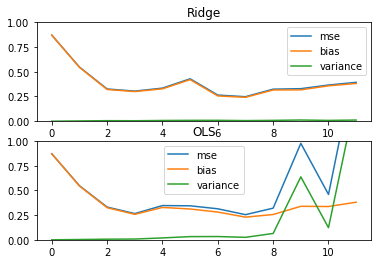

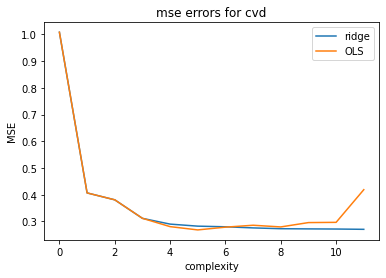

In [10]:
N = 20
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)
np.random.seed(64)

z = FrankeFunction(x_flat, y_flat, 0.15) 

#Bootstrap parameters
n_bootstraps = 1000
maxdegree = 12

#cross_validation parameters
k = 10
kfold = KFold(n_splits = k, shuffle=True, random_state=22)

polydegrees = np.zeros(maxdegree)

#Error arrays
mse_ridge_bootstrap = np.zeros(maxdegree)
mse_ols_bootstrap = np.zeros(maxdegree)

bias_ridge_bootstrap = np.zeros(maxdegree)
bias_ols_bootstrap = np.zeros(maxdegree)

variance_ridge_bootstrap = np.zeros(maxdegree)
variance_ols_bootstrap = np.zeros(maxdegree)

mse_ridge_cvd = np.zeros(maxdegree)
mse_ols_cvd = np.zeros(maxdegree)

for i in range(maxdegree):
    degree = i
    polydegrees[i] = degree
    X = create_X(x_flat, y_flat, degree)
    X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)
    X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)
    
    z_pred_ridge_bootstrap = np.empty((z_test.shape[0], n_bootstraps))
    z_pred_ols_bootstrap = np.empty((z_test.shape[0], n_bootstraps))
    
    for j in range(n_bootstraps):
        lmd = 1
        
        x_bs,z_bs = resample(X_train,z_train
                            )
        beta_ridge_bootstrap = np.linalg.pinv(x_bs.T @ x_bs + lmd*np.eye(x_bs.shape[1],x_bs.shape[1])) @ x_bs.T @ z_bs
        beta_ols_bootstrap = np.linalg.pinv(x_bs.T @ x_bs) @ x_bs.T @ z_bs
        
        z_pred_ridge_bootstrap[:,j] = X_test @ beta_ridge_bootstrap
        z_pred_ols_bootstrap[:,j] = X_test @ beta_ols_bootstrap
    
    #Bootstrap errors
    mse_ridge_bootstrap[i] = np.mean(np.mean((z_test.reshape(-1,1) - z_pred_ridge_bootstrap)**2, axis=1, keepdims=True))
    mse_ols_bootstrap[i] = np.mean(np.mean((z_test.reshape(-1,1) - z_pred_ols_bootstrap)**2, axis=1, keepdims=True))
    
    bias_ridge_bootstrap[i] = np.mean((z_test.reshape(-1,1) - np.mean(z_pred_ridge_bootstrap, axis=1, keepdims=True))**2)
    bias_ols_bootstrap[i] = np.mean((z_test.reshape(-1,1) - np.mean(z_pred_ols_bootstrap, axis=1, keepdims=True))**2)
    
    variance_ridge_bootstrap[i] = np.mean(np.var(z_pred_ridge_bootstrap, axis=1, keepdims=True))
    variance_ols_bootstrap[i] = np.mean(np.var(z_pred_ols_bootstrap, axis=1, keepdims=True))
    
    #print('Degree: %i    lambda: %.4f    mse_ridge: %.4f    mse_ols: %.4f    bias: %.4f    variance: %.4f'\
     #     %(degree, lmb, mse_ridge_bootstrap[i], mse_ols_bootstrap[i], bias_ridge_bootstrap[i],\
      #     variance_ols_bootstrap[i]))
    
    
    cv_split = 0
    mse_ols_cvd_split = np.zeros(k)
    mse_ridge_cvd_split = np.zeros(k)
    

    for train_indexes, test_indexes in kfold.split(X):
        X_train = X[train_indexes]
        X_test = X[test_indexes]
        z_train = z[train_indexes]
        z_test = z[test_indexes]
        X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)
        
        lmd = 0.01
        I_ = np.eye(X_train.shape[1], X_train.shape[1])
        
        beta_ols_cvd = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
        z_pred_ols_cvd = X_test @ beta_ols_cvd
        
        beta_ridge_cvd = np.linalg.pinv(X_train.T @ X_train + lmd*I_) @ X_train.T @ z_train
        z_pred_ridge_cvd = X_test @ beta_ridge_cvd
        
        mse_ols_cvd_split[cv_split] = mean_squared_error(z_test, z_pred_ols_cvd)
        mse_ridge_cvd_split[cv_split] = mean_squared_error(z_test, z_pred_ridge_cvd)
    
        cv_split += 1
    
    print('hei')
    # Cvd errors
    mse_ridge_cvd[i] = np.mean(mse_ridge_cvd_split)
    mse_ols_cvd[i] = np.mean(mse_ols_cvd_split)
    
    #print('Degree: %i    lambda: %.4f    mse_ridge: %.4f    mse_ols: %.4f' %(degree, lmb, mse_error_ridge_cvd[i], mse_error_ols_cvd[i]))


# Endre plot til subplots
fig,ax = plt.subplots(2, sharey=True)
ax[0].plot(polydegrees, mse_ridge_bootstrap, label='mse')
ax[0].plot(polydegrees, bias_ridge_bootstrap, label='bias')
ax[0].plot(polydegrees, variance_ridge_bootstrap, label='variance')
ax[0].set_ylim(0,1)
ax[0].legend()
ax[0].set_title('Ridge')

ax[1].plot(polydegrees, mse_ols_bootstrap, label='mse')
ax[1].plot(polydegrees, bias_ols_bootstrap, label='bias')
ax[1].plot(polydegrees, variance_ols_bootstrap, label='variance')
ax[1].legend()
ax[1].set_title('OLS')
plt.show()

fig,ax = plt.subplots(1, sharey=True)
ax.plot(polydegrees, mse_ridge_cvd, label='ridge')
ax.plot(polydegrees, mse_ols_cvd, label='OLS')
ax.set_xlabel('complexity')
ax.set_ylabel('MSE')
ax.legend()
plt.title('mse errors for cvd')
plt.show()

#### 6.2. Discussion of lambda dependence <a class="anchor" id="6.2"></a>

#### 6.3. Discussion of bias-variance trade-off  <a class="anchor" id="6.3"></a>

### 7. Exercise 5 - Lasso Regression on the Franke function with resampling
<a class="anchor" id="7"></a>

#### 7.1. Lasso regression

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:53

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:53

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:53

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:53

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:53

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:53

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:53

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:53

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:53

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.695488271472662, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:53

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6743812900494959, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1694941782154018, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6805307211782434, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-package

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-package

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-package

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-package

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-package

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-package

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-package

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-package

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-package

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-package

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-package

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-package

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0646027490327015, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-package

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.57998181310424, tolerance: 0.03200000000000001
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/s

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.268970590569964, tolerance: 0.032000000000000015
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-package

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-package

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-package

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-package

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-package

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-package

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-package

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-package

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-package

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-package

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-package

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-package

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171449007456516, tolerance: 0.031999999999999994
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-package

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8231687712164728, tolerance: 0.032
  model = cd_fast.enet_coordinate_descent(
/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py

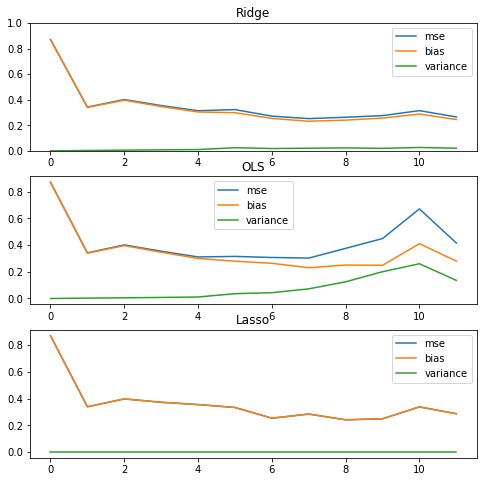

In [11]:
from sklearn.linear_model import Lasso

N = 20
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)
np.random.seed(64)

z = FrankeFunction(x_flat, y_flat, 0.15) 

#Bootstrap parameters
n_bootstraps = 400
maxdegree = 12

#cross_validation parameters
k = 5
kfold = KFold(n_splits = k, shuffle=True, random_state=22)

polydegrees = np.zeros(maxdegree)

#Error arrays

# Bootstrap
mse_ridge_bootstrap = np.zeros(maxdegree)
mse_ols_bootstrap = np.zeros(maxdegree)
mse_lasso_bootstrap = np.zeros(maxdegree)

bias_ridge_bootstrap = np.zeros(maxdegree)
bias_ols_bootstrap = np.zeros(maxdegree)
bias_lasso_bootstrap = np.zeros(maxdegree)

variance_ridge_bootstrap = np.zeros(maxdegree)
variance_ols_bootstrap = np.zeros(maxdegree)
variance_lasso_bootstrap = np.zeros(maxdegree)

# cvd
mse_ridge_cvd = np.zeros(maxdegree)
mse_ols_cvd = np.zeros(maxdegree)

for i in range(maxdegree):
    degree = i
    polydegrees[i] = degree
    X = create_X(x_flat, y_flat, degree)
    X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)
    X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)
    
    z_pred_ridge_bootstrap = np.empty((z_test.shape[0], n_bootstraps))
    z_pred_ols_bootstrap = np.empty((z_test.shape[0], n_bootstraps))
    z_pred_lasso_bootstrap = np.empty((z_test.shape[0], n_bootstraps))
    
    for j in range(n_bootstraps):
        lmd = 0.001
        
        x_bs,z_bs = resample(X_train,z_train)
        
        beta_ridge_bootstrap = np.linalg.pinv(x_bs.T @ x_bs + lmd*np.eye(x_bs.shape[1],x_bs.shape[1])) @ x_bs.T @ z_bs
        beta_ols_bootstrap = np.linalg.pinv(x_bs.T @ x_bs) @ x_bs.T @ z_bs
        
        z_pred_ridge_bootstrap[:,j] = X_test @ beta_ridge_bootstrap
        z_pred_ols_bootstrap[:,j] = X_test @ beta_ols_bootstrap
        
        reglasso = Lasso(lmd)
        reglasso.fit(X_train, z_train)
        z_pred_lasso_bootstrap[:,j] = reglasso.predict(X_test)
    
    #Bootstrap errors
    mse_ridge_bootstrap[i] = np.mean(np.mean((z_test.reshape(-1,1) - z_pred_ridge_bootstrap)**2, axis=1, keepdims=True))
    mse_ols_bootstrap[i] = np.mean(np.mean((z_test.reshape(-1,1) - z_pred_ols_bootstrap)**2, axis=1, keepdims=True))
    mse_lasso_bootstrap[i] = np.mean(np.mean((z_test.reshape(-1,1) - z_pred_lasso_bootstrap)**2, axis=1, keepdims=True))
    
    
    bias_ridge_bootstrap[i] = np.mean((z_test.reshape(-1,1) - np.mean(z_pred_ridge_bootstrap, axis=1, keepdims=True))**2)
    bias_ols_bootstrap[i] = np.mean((z_test.reshape(-1,1) - np.mean(z_pred_ols_bootstrap, axis=1, keepdims=True))**2)
    bias_lasso_bootstrap[i] = np.mean((z_test.reshape(-1,1) - np.mean(z_pred_lasso_bootstrap, axis=1, keepdims=True))**2)
    
    
    variance_ridge_bootstrap[i] = np.mean(np.var(z_pred_ridge_bootstrap, axis=1, keepdims=True))
    variance_ols_bootstrap[i] = np.mean(np.var(z_pred_ols_bootstrap, axis=1, keepdims=True))
    variance_lasso_bootstrap[i] = np.mean(np.var(z_pred_lasso_bootstrap, axis=1, keepdims=True))
    
    
    #print('Degree: %i    lambda: %.4f    mse_ridge: %.4f    mse_ols: %.4f    bias: %.4f    variance: %.4f'\
     #     %(degree, lmb, mse_ridge_bootstrap[i], mse_ols_bootstrap[i], bias_ridge_bootstrap[i],\
      #     variance_ols_bootstrap[i]))
    
    """"
    cv_split = 0
    mse_ols_cvd_split = np.zeros(k)
    mse_ridge_cvd_split = np.zeros(k)
    

    for train_indexes, test_indexes in kfold.split(X):
        X_train = X[train_indexes]
        X_test = X[test_indexes]
        z_train = z[train_indexes]
        z_test = z[test_indexes]
        X_train, X_test, z_train, z_test = scale(X_train, X_test, z_train, z_test)
        
        lmd = 0.01
        I_ = np.eye(X_train.shape[1], X_train.shape[1])
        
        beta_ols_cvd = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
        z_pred_ols_cvd = X_test @ beta_ols_cvd
        
        beta_ridge_cvd = np.linalg.pinv(X_train.T @ X_train + lmd*I_) @ X_train.T @ z_train
        z_pred_ridge_cvd = X_test @ beta_ridge_cvd
        
        mse_ols_cvd_split[cv_split] = mean_squared_error(z_test, z_pred_ols_cvd)
        mse_ridge_cvd_split[cv_split] = mean_squared_error(z_test, z_pred_ridge_cvd)
    
        cv_split += 1
    
    print('hei')
    # Cvd errors
    mse_ridge_cvd[i] = np.mean(mse_ridge_cvd_split)
    mse_ols_cvd[i] = np.mean(mse_ols_cvd_split)
    
    #print('Degree: %i    lambda: %.4f    mse_ridge: %.4f    mse_ols: %.4f' %(degree, lmd, mse_error_ridge_cvd[i], mse_error_ols_cvd[i]))
    """

# Bootstrap plots
fig,ax = plt.subplots(3,figsize=(8,8))
ax[0].plot(polydegrees, mse_ridge_bootstrap, label='mse')
ax[0].plot(polydegrees, bias_ridge_bootstrap, label='bias')
ax[0].plot(polydegrees, variance_ridge_bootstrap, label='variance')
ax[0].set_ylim(0,1)
ax[0].legend()
ax[0].set_title('Ridge')

ax[1].plot(polydegrees, mse_ols_bootstrap, label='mse')
ax[1].plot(polydegrees, bias_ols_bootstrap, label='bias')
ax[1].plot(polydegrees, variance_ols_bootstrap, label='variance')
ax[1].legend()
ax[1].set_title('OLS')

ax[2].plot(polydegrees, mse_lasso_bootstrap, label='mse')
ax[2].plot(polydegrees, bias_lasso_bootstrap, label='bias')
ax[2].plot(polydegrees, variance_lasso_bootstrap, label='variance')
ax[2].legend()
ax[2].set_title('Lasso')
"""
# cvd plot
fig,ax = plt.subplots(1)
ax.plot(polydegrees, mse_ridge_cvd, label='ridge')
ax.plot(polydegrees, mse_ols_cvd, label='OLS')
ax.set_xlabel('complexity')
ax.set_ylabel('MSE')
ax.legend()
plt.title('mse errors for cvd')
"""
plt.show()

#### 7.2. Evaluation of methods  <a class="anchor" id="7.2"></a>